In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls "/content/drive/MyDrive/DeepLearning/Common Literacy"

CommonLiteracyBertModels.ipynb		    CommonLiteracy_CNN_Model.ipynb
Common_Literacy_BOW_TFIDF_AvgW2V100D.ipynb  Dataset
Common_Literacy_BOW_TFIDF_AVGW2V300D.ipynb


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from mlxtend.regressor import StackingRegressor

# Gensim Models word2vec
import gensim
from gensim.models import Word2Vec
%matplotlib inline

In [4]:
train ='/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/train.csv'
test = '/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/test.csv'

In [5]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [6]:
print("This is train dataset")
print(df_train.head(2))
print(df_train.columns)
print("="*100)
print("This is test dataset")
print(df_test.head(2))
print(df_test.columns)

This is train dataset
          id url_legal  ...    target standard_error
0  c12129c31       NaN  ... -0.340259       0.464009
1  85aa80a4c       NaN  ... -0.315372       0.480805

[2 rows x 6 columns]
Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')
This is test dataset
          id  ...                                            excerpt
0  c0f722661  ...  My hope lay in Jack's promise that he would ke...
1  f0953f0a5  ...  Dotty continued to go to Mrs. Gray's every nig...

[2 rows x 4 columns]
Index(['id', 'url_legal', 'license', 'excerpt'], dtype='object')


Text(0, 0.5, 'Probability Density')

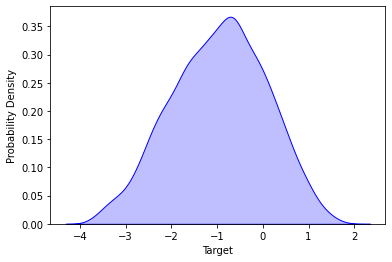

In [7]:
# plotting the KDE plot fot check the distribution of the dependents
import seaborn as sns

sns.kdeplot(df_train['target'], color='b', shade=True, Label='Target')
# Setting the X and Y Label
plt.xlabel('Target')
plt.ylabel('Probability Density')

In [8]:
# importing stopwords from nltk library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'ag

### Pretrained Glove Vector assignment

In [9]:
# Refer this for step by step method https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

!wget http://nlp.stanford.edu/data/glove.6B.zip # get the glove vector from stanford library

--2021-07-03 09:40:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-03 09:40:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-03 09:40:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [10]:
#unzip the downloaded glove vectors to drive
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [11]:
# creating the dictionary if word and vectors
print('Indexing word vectors.')

glove_300d = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_300d[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_300d))

Indexing word vectors.
Found 400000 word vectors.


In [12]:
# creating a set of the keys from glove dictionary
glove_words = set(glove_300d.keys())

In [13]:
# checking the dictionary word shape
print(glove_300d['the'].shape)

(300,)


In [14]:
# code to check for 3 dictionary values in text.
# import itertools
# # Initialize limit 
# N = 3
    
# # Using islice() + items() 
# # Get first N items in dictionary 
# out = dict(itertools.islice(glove_100d.items(), N)) 

# # printing result  
# print("Dictionary limited by K is : " + str(out))

### Cleaning the text data for any special characters and numerical characters

In [15]:
def testpreprocess(phrase):
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    return phrase

In [16]:
preprocessed_excerpt = []
for sentence in tqdm(df_train['excerpt'].values):
  sent = testpreprocess(sentence)
  sent = sent.lower().strip()
  sent = ' '.join(e for e in sent.split(" ") if e not in stopword)
  preprocessed_excerpt.append(sent)

df_train['cleaned_excerpt'] = preprocessed_excerpt

100%|██████████| 2834/2834 [00:01<00:00, 2451.06it/s]


In [17]:
# print(df_train['excerpt'].values[0])
# print("="*100)
# print(df_train['cleaned_excerpt'].values[:100])

In [18]:
print(df_train.columns)

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'cleaned_excerpt'],
      dtype='object')


### Glove Average Word 2 Vec Model

In [19]:
# Function to calculate the average word to vec for each sentence paragraph in the series
def Avg_W2V(selfie): # give a pandas series into
  # compute average word2vec for each review.
  AvgW2V_list = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(selfie.values): # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if word in glove_words: # this is set of glove vector keys
              vector += glove_300d[word] # this is adding the vector of 100 dimensions
              cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      AvgW2V_list.append(vector)
      # avgW2V_dict[sentence] = vector
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array


### Latent Dirichlet Allocation

In [20]:
lda_vectorizer = CountVectorizer()
corpus = lda_vectorizer.fit_transform(df_train['cleaned_excerpt'])
feature_names = lda_vectorizer.get_feature_names()
print(corpus.shape)
print(feature_names)

lda_model = LDA(n_components=6,max_iter=20,random_state=20)
X_topics = lda_model.fit_transform(corpus)
topic_words = lda_model.components_

(2834, 26660)
['00', '000', '000th', '001', '02', '03', '034', '04', '049', '06', '07', '070', '090', '0v', '10', '100', '1000', '100lbs', '1011', '1012', '1016', '1024', '105', '1050', '106', '108', '1095', '10am', '10th', '10x10', '11', '111', '112', '115', '1154', '116', '11a', '11and', '11b', '11th', '12', '120', '1200', '1223', '125', '127', '128', '129', '1291', '1299', '12th', '12x13', '13', '130', '1305', '132', '1328', '1337', '1340', '136', '1362', '1389', '13th', '13x14', '14', '140', '141', '1425', '142nd', '143', '1439', '144', '1453', '148', '149', '1490s', '1492', '1496', '14th', '15', '150', '1501', '1506', '1513', '1519', '1524', '1528', '1536', '1556', '156', '1580', '1585', '1592', '1598', '15th', '16', '1600', '1600s', '1607', '1608', '1610', '1613', '1615', '1624', '165', '1651', '1652', '165546', '167', '1670', '1683', '1688', '1699', '16ft', '16s', '16th', '17', '1700', '1700s', '1701', '1705', '171', '1710', '173', '1734', '1754', '1756', '1757', '1759', '1760',

In [21]:
n_top_words = 4

for i, topic_dist in enumerate(topic_words):
  print(topic_dist)
  sorted_topic_dist = np.argsort(topic_dist)
  print("="*100)
  print(sorted_topic_dist)
  topic_words_new = np.array(feature_names)[sorted_topic_dist]
  topic_words_new = topic_words_new[:-n_top_words:-1]
  print("Topic",str(i+1),topic_words_new)

[ 0.16674001 70.08362254  0.16666674 ...  0.16666668  1.16108188
  0.16666674]
[ 3141 24297 24298 ... 10776 17501 16629]
Topic 1 ['one' 'people' 'great']
[3.1657928  0.16734336 0.16805114 ... 0.1666667  0.16666686 0.16666678]
[ 3141 24297 24298 ... 20404 24812 16629]
Topic 2 ['one' 'two' 'room']
[0.16666679 0.1674839  0.16666684 ... 4.16647702 0.16666696 0.16666685]
[24297 24298  6202 ... 26429 14149 16629]
Topic 3 ['one' 'little' 'would']
[ 0.16736111 90.27994246  2.16528173 ...  0.16666668  0.17225059
  0.16666673]
[ 3141  6202  7035 ...  6991  1265 25285]
Topic 4 ['used' 'also' 'different']
[0.1667725  0.16685787 0.16666672 ... 0.1668562  0.16666675 1.16666606]
[ 3141 24297 24298 ... 16629 14149 20638]
Topic 5 ['said' 'little' 'one']
[0.16666678 4.13474987 0.16666684 ... 0.16666671 0.16666695 0.16666684]
[ 3141 17277 16663 ... 14497 14030 16629]
Topic 6 ['one' 'like' 'made']


### Splitting data into Train and cross validation(or test): Stratified Sampling

In [22]:
Y = df_train['target']
X = df_train['excerpt']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

In [24]:
print(X_train.head(5))

781     Goat, Dog and Cow were great friends. One day ...
2182    A French writer has recently published a caref...
992     The human brain is arguably the most complex s...
1431    This valley, two or three miles broad, stretch...
1850    The true social peril, hardly discovered befor...
Name: excerpt, dtype: object


### TF-IDF processing of text

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_tfidf = vectorizer.transform(X_train)
X_test_excerpt_tfidf = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_tfidf.shape, Y_train.shape)
print(X_test_excerpt_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 12222) (1898,)
(936, 12222) (936,)


### Bag of Words 

In [26]:
vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_bow = vectorizer.transform(X_train)
X_test_excerpt_bow = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_bow.shape, Y_train.shape)
print(X_test_excerpt_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 12222) (1898,)
(936, 12222) (936,)


### Average Word to Vector Representation for 300 dimension

In [27]:
X_train_excerpt_avgw2v = Avg_W2V(X_train)
X_test_excerpt_avgw2v = Avg_W2V(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_avgw2v.shape, Y_train.shape)
print(X_test_excerpt_avgw2v.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:00<00:00, 2991.22it/s]

After vectorizations
(1898, 300) (1898,)
(936, 300) (936,)


# Various Models

### Linear Regression

In [28]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_tfidf, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_tfidf,Y_train)

Y_pred = lr.predict(X_test_excerpt_tfidf)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[0.40910677 0.42072207 0.46264676 0.48958655 0.41218439] 0.43884930927500054 0.031827093855304446
This is root mean square error:  0.7413518065818988


In [29]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_bow, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_bow,Y_train)

Y_pred = lr.predict(X_test_excerpt_bow)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[0.29895334 0.33918374 0.41254813 0.42534778 0.36337238] 0.3678810739712537 0.04667433245914116
This is root mean square error:  0.7941083691495542


### Function to run all models together

In [30]:
# data = {"Bag of Words":(X_train_excerpt_bow,X_test_excerpt_bow),"TF-IDF":(X_train_excerpt_tfidf,X_test_excerpt_tfidf),"Avg Word2Vec":(X_train_excerpt_avgw2v,X_test_excerpt_avgw2v)}
data = {"Avg Word2Vec":(X_train_excerpt_avgw2v,X_test_excerpt_avgw2v)}

def modelfunction(modelname,data,Y_train,Y_test,param):
  for key,value in tqdm(data.items()):
    train = value[0]
    test = value[1]
    gscv = GridSearchCV(modelname, param_grid=param,cv=5,verbose=10,n_jobs=-1)
    results = gscv.fit(train, Y_train)
    best_estimate = gscv.best_estimator_

    Y_pred_train = best_estimate.predict(train)
    train_residuals = Y_train - Y_pred_train
    Y_pred_test = best_estimate.predict(test)
    test_residuals = Y_test - Y_pred_test
    mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
    mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

    print("-"*100)
    print("The model is run on {}: ".format(key))
    print("="*100)
    print(best_estimate)
    print("*"*50)
    print("Root Mean squared Error Train for {}: ".format(key), np.sqrt(mse_train))
    print("Root Mean squared Error Test for {}: ".format(key), np.sqrt(mse_test))

    plt.subplot(1,2,1)
    plt.scatter(train_residuals.index,train_residuals)
    plt.title("Train Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')

    plt.subplot(1,2,2)
    plt.scatter(test_residuals.index,test_residuals)
    plt.title("Test Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')
    plt.show()

    return Y_pred_train,Y_pred_test

### Lasso Regression

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1746s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0649s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    3.7s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.6758961105036582
Root Mean squared Error Test for Avg Word2Vec:  0.700633768162455


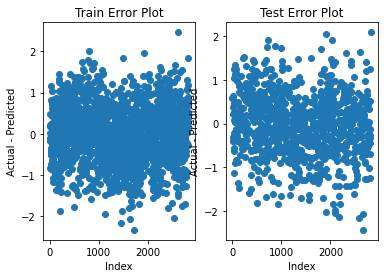

  0%|          | 0/1 [00:04<?, ?it/s]


In [31]:
lasso_params = {'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}
lasso = Lasso()

Y_pred_train_Lasso,Y_pred_test_Lasso = modelfunction(lasso,data,Y_train,Y_test,lasso_params)

### Ridge Regression

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0374s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0738s.) Setting batch_size=4.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1499s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
Ridge(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.6694398687684258
Root Mean squared Error Test for Avg Word2Vec:  0.6926798490219708


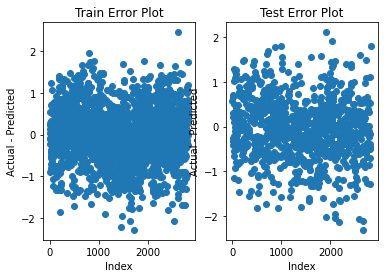

  0%|          | 0/1 [00:01<?, ?it/s]


In [32]:
ridge_params = {'alpha':[0.35,0.4,0.5,0.6,0.8,1.0,1.5,2.0,3.0,4>0,5.0,6.0,10.0,15.0,20.0]}
ridge = Ridge()

Y_pred_train_Ridge,Y_pred_test_Ridge = modelfunction(ridge,data,Y_train,Y_test,ridge_params)

### SGD Regressor

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1992s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    5.5s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.7674163875872287
Root Mean squared Error Test for Avg Word2Vec:  0.7502069890874333


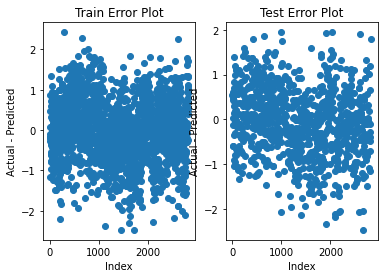

  0%|          | 0/1 [00:06<?, ?it/s]


In [33]:
SGD_params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,0.2,0.3],'penalty':['l1','l2']}
SGD = SGDRegressor()

Y_pred_train_SGD,Y_pred_test_SGD = modelfunction(SGD,data,Y_train,Y_test,SGD_params)

### KNN Regression

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   13.9s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.7462827837281056
Root Mean squared Error Test for Avg Word2Vec:  0.742361076185266


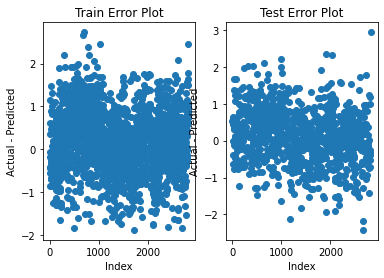

In [34]:
KNN_params = {'n_neighbors':[7,8,10,15,20,30,40,50,80,90,100],'algorithm':['kd_tree']}
KNN = KNeighborsRegressor()

Y_pred_train_KNN,Y_pred_test_KNN = modelfunction(KNN,data,Y_train,Y_test,KNN_params)

### Linear SVR


  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   25.6s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.6761213313799321
Root Mean squared Error Test for Avg Word2Vec:  0.6977208103900924


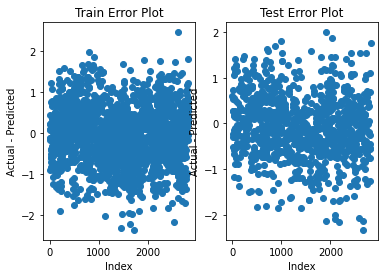

In [35]:
SVR_params = {'C':[0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0]}
LinearSVR = SVR(kernel='linear')

Y_pred_train_LinearSVR,Y_pred_test_LinearSVR = modelfunction(LinearSVR,data,Y_train,Y_test,SVR_params)

### RBF SVR



  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   55.2s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
SVR(C=80, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.6728601416530353
Root Mean squared Error Test for Avg Word2Vec:  0.6964861494019464


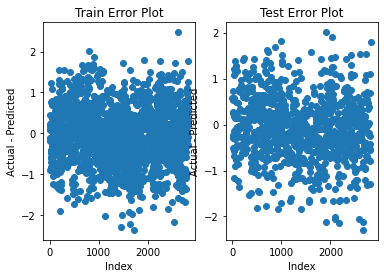

In [36]:
SVR_params = {'C':[10.0,20,30,50,80,100,150,200,300,400,500,600,700,900,1000]}
RBF_SVR = SVR(kernel='rbf',gamma="auto")

Y_pred_train_RBF_SVR,Y_pred_test_RBF_SVR = modelfunction(RBF_SVR,data,Y_train,Y_test,SVR_params)

### Random Forest




  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.5min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.2859420385036439
Root Mean squared Error Test for Avg Word2Vec:  0.726844832055764


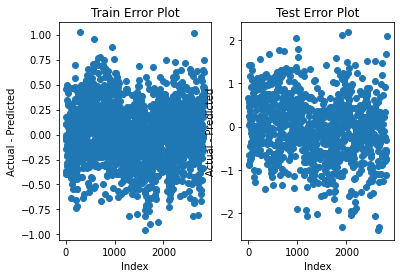

In [37]:
RF_params = {'n_estimators':[10,20,30,50,70,90,100]}

RandomForest = RandomForestRegressor()
Y_pred_train_RandomForest,Y_pred_test_RandomForest = modelfunction(RandomForest,data,Y_train,Y_test,RF_params)





  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


[09:54:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
**************************************************
Root Mean squared Error Train for Avg Word2Vec:  0.3816172369175331
Root Mean squared Error Test for Avg Word2Vec:  0.6924548898658135


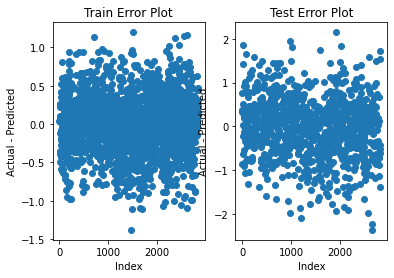

In [38]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

xgb = XGBRegressor()
Y_pred_train_XGB,Y_pred_test_XGB = modelfunction(xgb,data,Y_train,Y_test,xgb_params)

### Combining all the Predicted Values into a Data Frame

In [39]:
# Saving the prediction value to a dataframe
prediction_train = pd.DataFrame(Y_pred_train_Lasso, columns = ['Lasso'])
prediction_test = pd.DataFrame(Y_pred_test_Lasso, columns = ['Lasso'])

prediction_train['Ridge'] = Y_pred_train_Ridge
prediction_test['Ridge'] = Y_pred_test_Ridge
prediction_train['SGD'] = Y_pred_train_SGD
prediction_test['SGD'] = Y_pred_test_SGD
prediction_train['KNN'] = Y_pred_train_KNN
prediction_test['KNN'] = Y_pred_test_KNN
prediction_train['LinearSVR'] = Y_pred_train_LinearSVR
prediction_test['LinearSVR'] = Y_pred_test_LinearSVR
prediction_train['RBF_SVR'] = Y_pred_train_RBF_SVR
prediction_test['RBF_SVR'] = Y_pred_test_RBF_SVR
prediction_train['RandomForest'] = Y_pred_train_RandomForest
prediction_test['RandomForest'] = Y_pred_test_RandomForest
prediction_train['XGB'] = Y_pred_train_XGB
prediction_test['XGB'] = Y_pred_test_XGB


print(prediction_train.head(5))

      Lasso     Ridge       SGD  ...   RBF_SVR  RandomForest       XGB
0 -0.560142 -0.431275 -0.515183  ... -0.438477      0.388759  0.387062
1 -1.720314 -1.910348 -1.878501  ... -1.938542     -2.317982 -2.138859
2 -1.270393 -1.260993 -1.299476  ... -1.278140     -1.320820 -1.476566
3 -1.232783 -1.346488 -1.073171  ... -1.288305     -1.279370 -1.315135
4 -1.983374 -1.966851 -1.376443  ... -1.914271     -2.540794 -2.377724

[5 rows x 8 columns]


### Stacking Regressor

In [47]:
# Regressors
LR = Lasso(alpha=0.0005)
RR = Ridge(alpha=1.5)
SGD = SGDRegressor(alpha=0.00001, penalty='l1')
KNN = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=20, p=2,)
L_SVR = SVR(C=0.4,kernel='linear')
R_SVR = SVR(C=80, kernel='rbf')
RF = RandomForestRegressor(n_estimators=100)
XGB_R = XGBRegressor(learning_rate=0.1, n_estimators=180)

# Meta Classifier
SVR_RBF = SVR(kernel='rbf')
XGB_Meta = XGBRegressor()
lr_meta = LinearRegression()

Stack_Regress = StackingRegressor(regressors=[LR,RR,L_SVR,R_SVR,XGB_R],meta_regressor=lr_meta)

Stack_Results = Stack_Regress.fit(X_train_excerpt_avgw2v, Y_train)

Y_pred_train = Stack_Results.predict(X_train_excerpt_avgw2v)
train_residuals = Y_train - Y_pred_train
Y_pred_test = Stack_Results.predict(X_test_excerpt_avgw2v)
test_residuals = Y_test - Y_pred_test
mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

print("="*100)
print("Root Mean squared Error Train for Stacking Model", np.sqrt(mse_train))
print("Root Mean squared Error Test for Stacking Model", np.sqrt(mse_test))

[12:04:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean squared Error Train for Stacking Model 0.2931514076788577
Root Mean squared Error Test for Stacking Model 0.7204195887593047
